In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from agentic_dqn import DQNAgent
from agentic_dqn import Memory as mem
from utils import running_mean

In [2]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins=5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action / (self.bins - 1.0) * (
            self.orig_action_space.high - self.orig_action_space.low
        )


In [3]:
seed1 = 7489
seed2 = 1312

SEEDS_TEST = [291, 292, 293, 294, 295] 
torch.manual_seed(seed1)
np.random.seed(seed1)

### Test in env 

In [4]:
env_name = 'Pendulum-v1'
# env_name = 'CartPole-v0'

env = gym.make(env_name)
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(5)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
[(np.float32(-1.0), np.float32(1.0)), (np.float32(-1.0), np.float32(1.0)), (np.float32(-8.0), np.float32(8.0))]


In [5]:
use_target = True
target_update = 20
q_agent = DQNAgent(o_space, ac_space,mem, discount=0.95, eps=0.2, 
                   use_target_net=use_target, update_target_every= target_update)

/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [6]:
ob,_info = env.reset()
q_agent.Q.predict(ob)


stats = []
losses = []

In [7]:
max_episodes=400
max_steps=500 
frameidx=0
time_start = time.time()
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        frameidx += 1 
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))
print("Time per frame taken: ", (time.time()-time_start)/frameidx)
print("mean sample time: ", np.mean(q_agent.sample_times))

1: Done after 500 steps. Reward: -3278.838382971642
21: Done after 500 steps. Reward: -3381.6196254923143
41: Done after 500 steps. Reward: -3263.0756464811716
61: Done after 500 steps. Reward: -4166.870757123168
81: Done after 500 steps. Reward: -3221.7454136985407
101: Done after 500 steps. Reward: -2663.8319071922206
121: Done after 500 steps. Reward: -3126.37863121811
141: Done after 500 steps. Reward: -2966.551376780183
161: Done after 500 steps. Reward: -3006.346902802965
181: Done after 500 steps. Reward: -1986.6587113899607
201: Done after 500 steps. Reward: -1624.4720700239989
221: Done after 500 steps. Reward: -1139.2415564540215
241: Done after 500 steps. Reward: -653.6163847559205
261: Done after 500 steps. Reward: -1768.4841299839995
281: Done after 500 steps. Reward: -757.3838553172313
301: Done after 500 steps. Reward: -2375.892267384698
321: Done after 500 steps. Reward: -381.5774507913358
341: Done after 500 steps. Reward: -495.4228922264654
361: Done after 500 steps. 

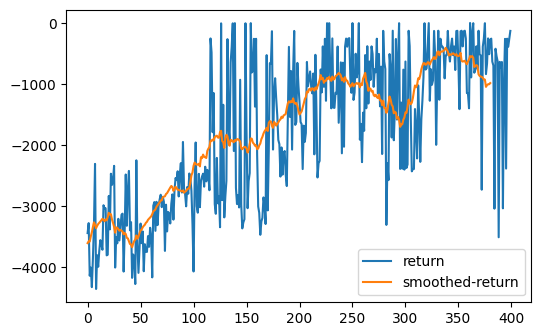

In [8]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

In [9]:
fig.savefig(f"DQN_{env_name}_training_w_target_{use_target}-update-{target_update}.pdf")

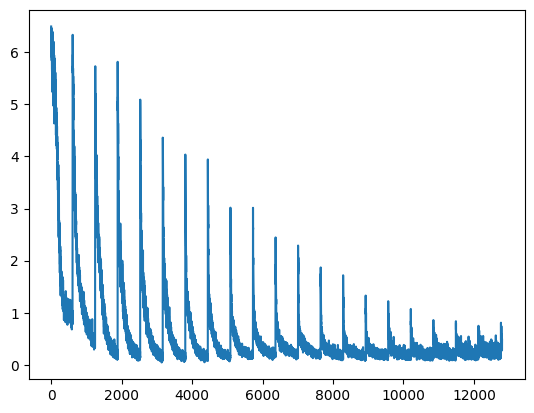

In [10]:
plt.figure()
plt.plot(losses_np)

In [11]:
q_agent.buffer.size

100000

# Evaluate 

In [12]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [13]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1]) 

In [14]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-515.7001262811119 +- 1133.595487854793
